In [1]:
cd /Users/eisukeokuda/Research-Project/

/Users/eisukeokuda/Research-Project


In [107]:
import csv
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import (
    preprocess_contigs,
    label_to_id,
    get_threshold_dataset_indices
)

import os
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

In [211]:
contig_path = "data/metahit/contigs.fna.gz"
taxonomy_path = "data/metahit/taxonomy.tsv"
contig_processed_path = "data/species_labelled_contigs.csv"
threshold_dataset_indices_path = "data/threshold_dataset_indices.npy"
model_configs = "config/models.yml"

results_path = "results/heatmap"

# Read Model Configs
with open(model_configs, "r") as model_file:
    models_config = yaml.safe_load(model_file)

# Read DNA Sequences
preprocess_contigs(contig_path, contig_processed_path)

# Read Processed DNA Sequences
with open(contig_processed_path) as csvfile:
    data = list(csv.reader(csvfile, delimiter=","))
dna_sequences = [i[1] for i in data[1:]]
label_ids, id2label = label_to_id(data)

threshold_dataset_indices = get_threshold_dataset_indices(label_ids, threshold_dataset_indices_path)
labels_evaluate = label_ids[threshold_dataset_indices == 0]

# Read Taxonomy
taxon = pd.read_csv(taxonomy_path, delimiter='\t', header=None)
species2genus = dict(zip(taxon[0], taxon[2]))
id2genus = {i: label for i, label in enumerate(taxon[2])}
genus2id = {label: i for i, label in enumerate(taxon[2])}

# Assign a genus label to each strain
unique_id = np.unique(labels_evaluate)

label_ids_genus = np.array([genus2id[species2genus[id2label[l]]] for l in unique_id])

CSV file already exists at data/species_labelled_contigs.csv
Loading threshold dataset indices
Threshold dataset comprise 18666 contigs (10.5%)



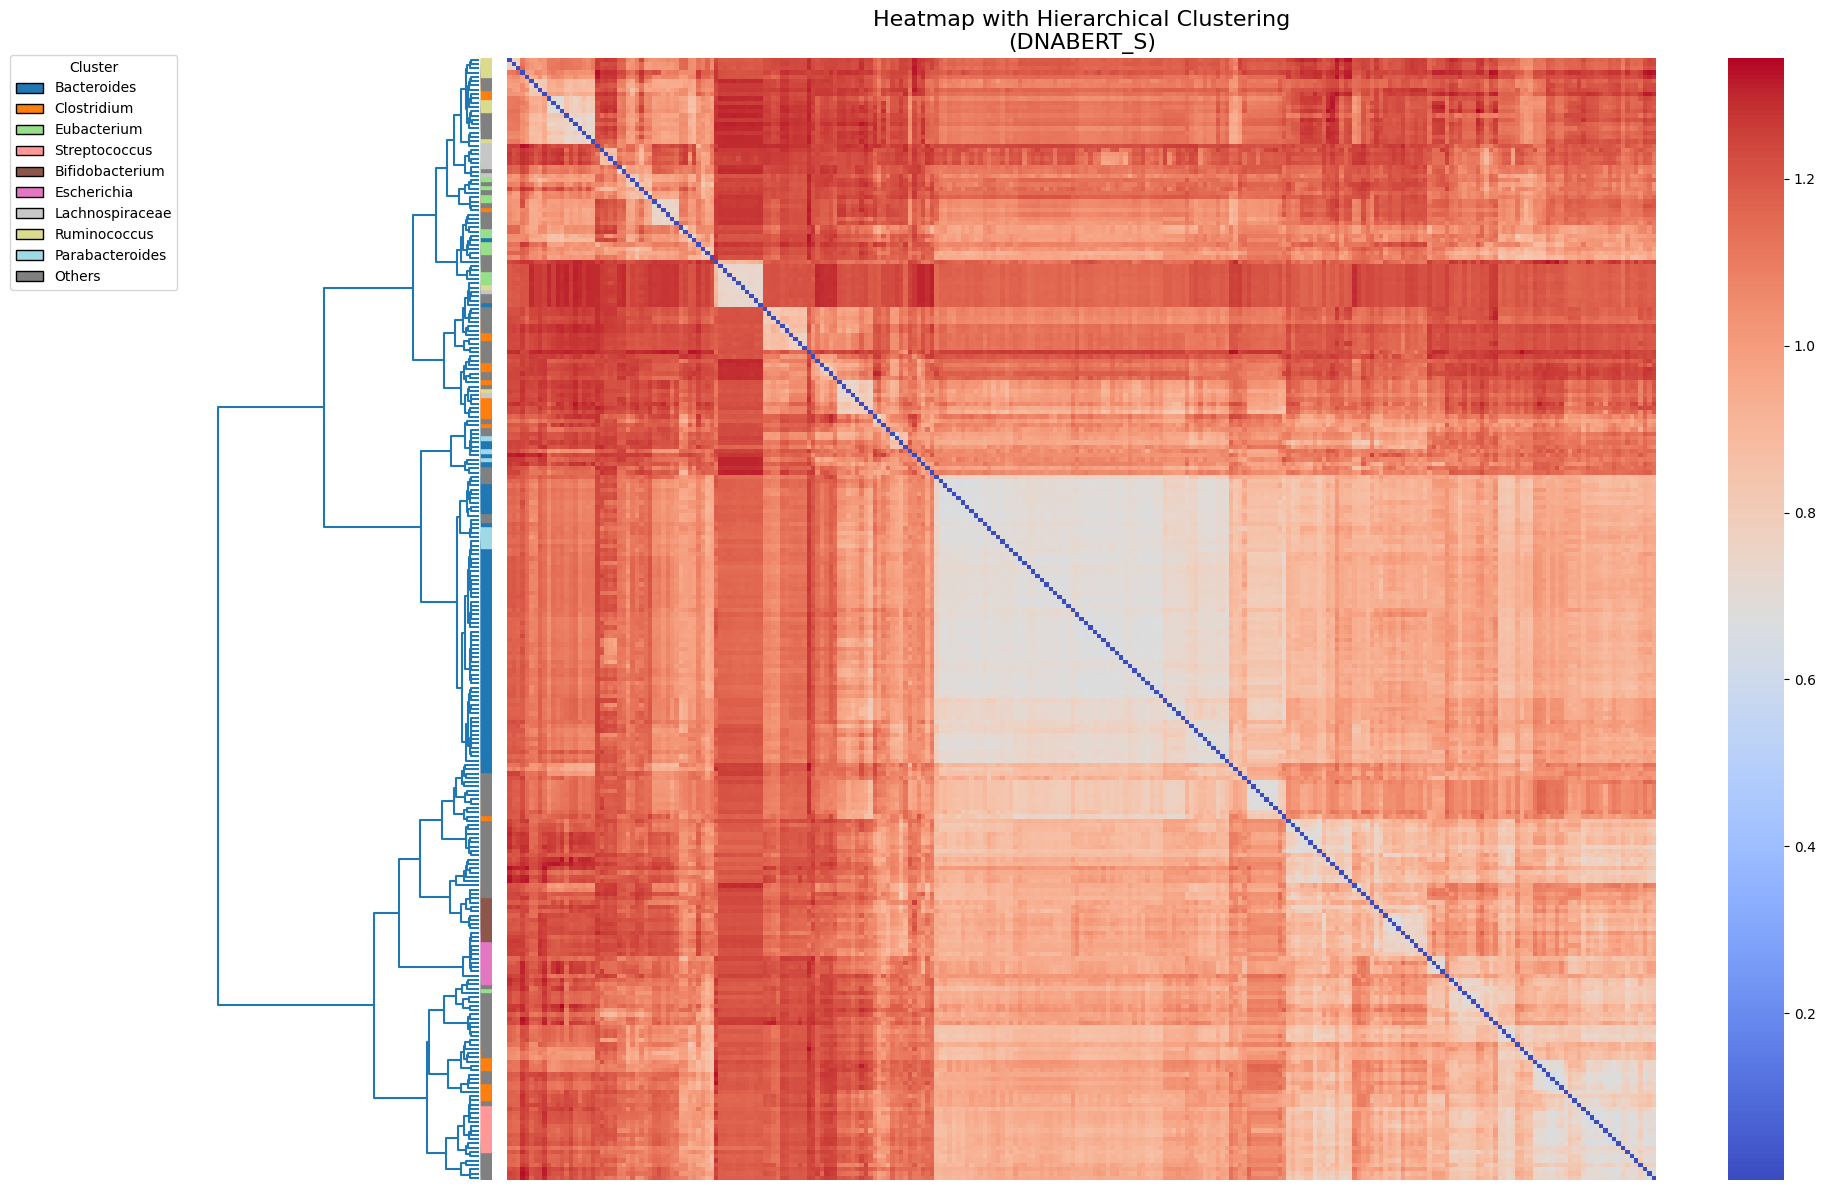

In [215]:
    
# Preprocessing for visualizing top 9 frequent genus
label_ids_mask = label_ids_genus.copy()
unique_genus, count = np.unique(label_ids_genus, return_counts=True)

# Assign the same label (999) for infrequent genus
mask = unique_genus[count<7.25]
label_ids_mask[np.isin(label_ids_genus, mask)] = 999

# Create a color dictionary
unique_mask, counts = np.unique(label_ids_mask, return_counts=True)
unique_labels = unique_mask[unique_mask!=999]
counts = counts[unique_mask!=999]
unique_labels = unique_labels[np.argsort(-counts)]
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
color_dict = {label: color for label, color in zip(unique_labels, colors)}
unique_mask = np.append(unique_labels, 999)
color_dict[999] = (0.5, 0.5, 0.5, 1.0)
id2genus[999] = 'Others'
genus2id['Others'] = 999

for model_name in models_config.keys():   
    # Load a distance matrix for each model
    model_results_path = os.path.join(results_path, f"{model_name}_dist_mtx.npy")
    distance_matrix = np.load(model_results_path)

    # Create the hierarchical linkage matrix using Ward's method
    linkage = sch.linkage(distance_matrix, method='ward')

    # Create cluster labels using fcluster with a maximum of 64 clusters
    if model_name == "DNABERT_S":
        cluster_labels = fcluster(linkage, t=len(np.unique(label_ids_genus)), criterion='maxclust')

    # Create a figure with two subplots: dendrogram and heatmap
    fig, ax = plt.subplots(1, 2, figsize=(18, 12), gridspec_kw={'width_ratios': [1, 5]})
    plt.subplots_adjust(left=0.8)

    # Plot the dendrogram on the left without labels and disable automatic color assignment
    dendrogram = sch.dendrogram(
        linkage,
        orientation='left',
        ax=ax[0],
        no_labels=True,
        color_threshold=0 
    )
    ax[0].axis('off') 

    # Retrieve the order of leaves in the dendrogram
    leaf_order = dendrogram['leaves']
    N = len(leaf_order)

    # Get the y-axis limits to determine the positioning of the dots
    y_min, y_max = ax[0].get_ylim()

    # Evenly distribute y-positions for each leaf
    y_positions = np.linspace(y_min, y_max, N)

    # Retrieve the corresponding colors for each leaf based on the color dictionary
    leaf_colors = [color_dict.get(label_ids_mask[leaf], 'black') for leaf in leaf_order]

    # Determine the x-position for the dots, slightly to the right of the dendrogram
    x_min, x_max = ax[0].get_xlim()
    dot_x = x_max + (x_max - x_min) * 0.05  

    # Adjust the x-axis limits to accommodate the dots
    ax[0].set_xlim(x_min, dot_x)

    # Plot colored dots to the right of the dendrogram
    scatter = ax[0].scatter(
        [dot_x] * N,     
        y_positions,      
        c=leaf_colors,    
        s=250,            
        marker='s',
        zorder=5         
    )

    # Create a color legend
    unique_colors = list(color_dict.values())
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=id2genus[label]) for label, color in zip(unique_mask, unique_colors)]

    # Add the legend to the dendrogram axis
    fig.legend(handles=legend_elements, title="Cluster", bbox_to_anchor=(-0.1, 0.95), loc='upper left', borderaxespad=0.)

    # Sort the distance matrix according to the clustering result
    sorted_idx = sch.leaves_list(linkage)
    sorted_matrix = distance_matrix[sorted_idx][:, sorted_idx]

    # Create a heatmap of the sorted distance matrix
    sns.heatmap(
        sorted_matrix,
        ax=ax[1],
        cmap='coolwarm',
        cbar=True,
        xticklabels=False,
        yticklabels=False
    )
    ax[1].set_title(f"Heatmap with Hierarchical Clustering\n({model_name})", fontsize=16)

    # Adjust the layout for better spacing
    plt.tight_layout()

    # Save the resulting plot to the specified file path
    plt.savefig(f"figures/{model_name}_heatmap.svg", bbox_inches='tight')
    if model_name == "DNABERT_S":
        plt.show()
    plt.close()


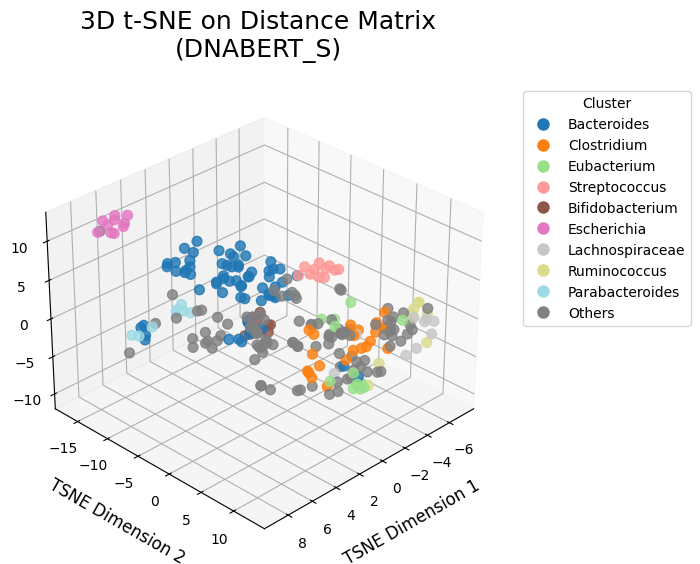

In [246]:
# Map a color to its corresponding label
label_colors = [color_dict[l] for l in label_ids_mask]

for model_name in models_config.keys():  
    # Load a distance matrix for each model
    model_results_path = os.path.join(results_path, f"{model_name}_dist_mtx.npy")
    distance_matrix = np.load(model_results_path)
    
    # Initialize t-SNE with 3 components and precomputed metric
    tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random', perplexity=17)

    # Compute the t-SNE embedding
    tsne_results = tsne.fit_transform(distance_matrix)

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot the t-SNE results
    scatter = ax.scatter(
        tsne_results[:, 0], 
        tsne_results[:, 1], 
        tsne_results[:, 2],  
        c=label_colors,             
        s=50,                 
        alpha=0.8             
    )

    handles = [plt.Line2D([0], [0], marker='o', color='w', label=id2genus[label],
                          markerfacecolor=color_dict[label], markersize=10) for label in unique_mask]
    ax.legend(handles=handles, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set plot title and axis labels with increased labelpad
    ax.set_title(f'3D t-SNE on Distance Matrix\n({model_name})', fontsize=18, pad=20)
    ax.set_xlabel('TSNE Dimension 1', fontsize=12, labelpad=10)
    ax.set_ylabel('TSNE Dimension 2', fontsize=12, labelpad=10)
    ax.set_zlabel('TSNE Dimension 3', fontsize=12, labelpad=10)

    # Optionally, adjust the viewing angle for better visualization
    ax.view_init(elev=30, azim=45)

    # Adjust the layout to make room for the z-axis label
    plt.tight_layout(pad=2.0)  

    # Save the plot to the specified path with additional padding
    plt.savefig(f"figures/{model_name}_tsne.svg", dpi=300, bbox_inches='tight', pad_inches=0.5)
    if model_name == "DNABERT_S":
        plt.show()
    plt.close(fig)

In [217]:
def assign_num_labels(labels, unique_labels):
    label2id_dict = {}
    id2label_dict = {}
    for idx, label in enumerate(unique_labels):
        label2id_dict[label] = idx
        id2label_dict[idx] = label
    new_labels = np.array([label2id_dict[l] for l in labels])
    return new_labels, id2label_dict

# Reassign labels to create a confusion matrix
true_labels, true_dict = assign_num_labels(label_ids_mask, unique_mask)
pred_labels, _ = assign_num_labels(cluster_labels, np.unique(cluster_labels))

# Create a confusion matrix
confusion_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(pred_labels))), dtype=int)

for true_label, predicted_label in zip(true_labels, pred_labels):
    confusion_matrix[true_label, predicted_label] += 1

print(confusion_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0 18 13 21  0  8  0  0  4  0  0  0  0  0
   0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  4  1  2
   0  0  2  0  0  0  0  0  0  1  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  3  3  2  0  0  2  1  1  0  0  0]
 [ 0  0  0  0  4  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  6  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 

In [218]:
# Identify the cluster number with most counts
keep_indices = []

for i in range(9):
    keep_indices.append(confusion_matrix[i].argmax())
    print(f"{id2genus[true_dict[i]]}: {confusion_matrix[i].argmax()}")

all_indices = set(range(confusion_matrix.shape[1]))
combine_indices = list(all_indices - set(keep_indices))

# Calculate a non-zero average on axis=1
non_zero_counts = np.count_nonzero(confusion_matrix[:, combine_indices], axis=1)
sum_combined = confusion_matrix[:, combine_indices].sum(axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    combined_average = np.where(non_zero_counts != 0, sum_combined / non_zero_counts, 0)

# Create a new 10x10 matrix
combined_column_sum = confusion_matrix[:, combine_indices].sum(axis=1).reshape(-1, 1)
combined_column_avg = combined_average.reshape(-1, 1)
kept_columns = confusion_matrix[:, keep_indices]
confusion_matrix_ = np.concatenate([kept_columns, combined_column_avg], axis=1)

print(confusion_matrix_)

Bacteroides: 37
Clostridium: 6
Eubacterium: 53
Streptococcus: 5
Bifidobacterium: 20
Escherichia: 17
Lachnospiraceae: 61
Ruminococcus: 63
Parabacteroides: 38
[[21.          0.          0.          0.          0.          0.
   0.          0.          0.          7.5       ]
 [ 0.          4.          0.          0.          0.          0.
   0.          2.          0.          1.77777778]
 [ 0.          0.          3.          0.          0.          0.
   0.          0.          0.          1.66666667]
 [ 0.          0.          0.          7.          0.          0.
   0.          0.          0.          4.        ]
 [ 0.          0.          0.          0.          6.          0.
   0.          0.          0.          4.        ]
 [ 0.          0.          0.          0.          0.         10.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   3.          0.          0.          1.5       ]
 [ 0.          0.       

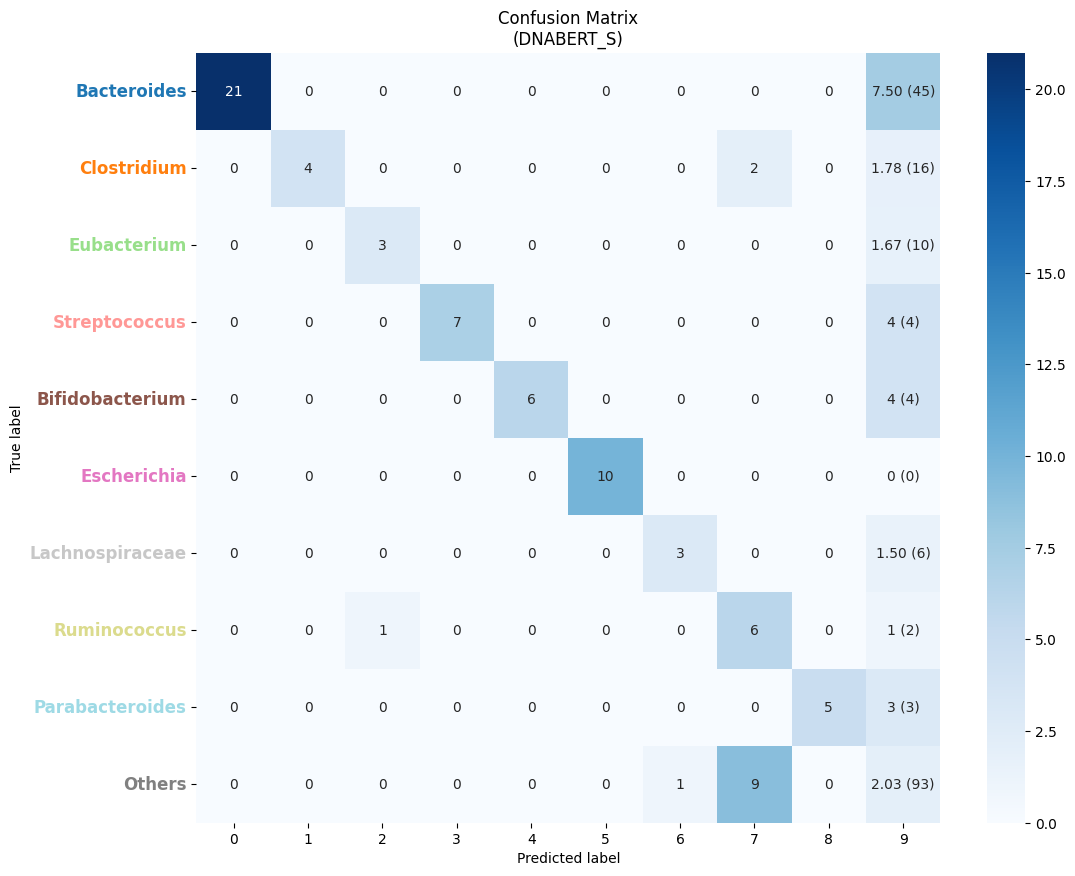

In [219]:
import math
# Custom functions made for this plot
def round_up_two_decimals(value):
    scaled_value = value * 100  
    ceiling_value = math.ceil(scaled_value)  
    rounded_value = ceiling_value / 100  
    return rounded_value


def format_value(value):
    if value == int(value):
        return f"{int(value)}"
    else:
        return f"{value:.2f}"

class_labels = [id2genus[l] for l in unique_mask]

plt.figure(figsize=(12, 10))

annot_text = []
for idx, row in enumerate(confusion_matrix_):
    row_text = [f"{int(cell)}" for cell in row[:-1]]
    
    avg_value = combined_column_avg[idx][0]
    sum_value = combined_column_sum[idx][0]  
    rounded_avg = round_up_two_decimals(avg_value)
    formatted_avg = format_value(rounded_avg)
    formatted_sum = f"{int(sum_value)}"
    
    
    rightmost_annotation = f"{formatted_avg} ({formatted_sum})"
    
    row_text.append(rightmost_annotation)
    annot_text.append(row_text)

annot_text = np.array(annot_text)

ax = sns.heatmap(confusion_matrix_, annot=annot_text, fmt='', cmap='Blues', vmin=confusion_matrix_.min(), vmax=confusion_matrix_.max(), cbar=True,
            xticklabels=[i for i in range(10)], yticklabels=class_labels)

for tick in ax.get_yticklabels():
    label = genus2id[tick.get_text()]
    if label in color_dict:
        tick.set_color(color_dict[label])
    tick.set_fontsize(12)            
    tick.set_fontweight('bold')   

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix\n(DNABERT_S)')

# Save the plot to the specified path with additional padding
plt.savefig(f"figures/DNABERT_S_cm.svg", dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()